<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Image Display and Manipulation</b> <br>
Contact authors: Alex Drlica-Wagner, Jeff Carlin <br>
Last verified to run: 2022-09-29 <br>
LSST Science Piplines version: Weekly 2022_40 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** Learn to display and manipulate images using the LSST Science Pipelines.

**Skills:** Display and manipulate images, explore image mask planes, create cutouts and RGB images.

**LSST Data Products:** Butler calexp and deepCoadd images, coadd objectTable

**Packages:** lsst.afw.display, lsst.daf.butler, lsst.geom, lsst.afw.image

**Credit:** This tutorial is based on the [`AFW_Display_Demo.ipynb`](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Visualization/AFW_Display_Demo.ipynb) notebook originally written by Brant Robertson and maintained by the LSST Stack Club.

More examples of the use of `lsst.afw.display` can be found in the [LSST Science Pipelines documentation](https://pipelines.lsst.io/getting-started/display.html).

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>.
Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial is designed to help users get a brief feel for the `lsst.afw.display` library that enables the visual inspection of image data. The [`lsst.afw` library](https://github.com/lsst/afw) provides an "Astronomical Framework" (afw) while the `lsst.daf.*` libraries (see, e.g., [daf_base](https://github.com/lsst/daf_base)) provides a "Data Access Framework" (daf). Both libraries are used in this tutorial, with the `lsst.daf.butler` library used to access image data and the `lsst.afw.display` library used to show the exposure image on the screen using the matplotlib backend.

### 1.1 Package Imports

The [`matplotlib`](https://matplotlib.org/), [`numpy`](http://www.numpy.org/), and [`astropy`](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis. We will use these packages below, including the `matplotlib.pyplot` plotting sublibrary and the [`astropy.wcs`](https://docs.astropy.org/en/stable/wcs/index.html) package for dealing with World Coordinate Systems (WCS). We also import the [`warnings` library](https://docs.python.org/2/library/warnings.html) to prevent some routine warning messages from printing to the screen.

We load the `lsst.afw.display` library to gain access to the image visualization routines we'd like to use, and the `lsst.daf.butler` library, which is used to access data products.

In [1]:
import matplotlib.pyplot as plt
import gc

# Astropy imports
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Image visualization routines.
import lsst.afw.display as afwDisplay
# The Butler provides programmatic access to LSST data products.
from lsst.daf.butler import Butler
# Geometry package
import lsst.geom as geom
# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

plt.style.use('tableau-colorblind10')
%matplotlib inline

### 1.2 Define Functions and Parameters

Matplotlib stores the data array associated with an image that is plotted. Since the LSST CCD detector images are large (~4k x 4k pixels), this can eventually lead to a memory overflow, which will cause the notebook kernel to die. To mitigate this issue, we define a function to clean up after we plot them.

In [2]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

<a id="cutout_coadd"></a>

Next we define a function to produce a cutout image from a coadd at the user-provided ra, dec.

In [3]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

<a id="create_rgb"></a>

Below we define a function that we will use to produce a color (RGB) image from a set of input images taken with three different filters. We'll use a tool from Astropy (`make_lupton_rgb`) that helps create RGB images (see [this Astropy guide to creating RGB images](https://docs.astropy.org/en/stable/visualization/rgb.html?highlight=make_lupton_rgb) for more info), and make a convenience function to combine the steps of making an RGB image. (This function was originally written by Aaron Watkins and Nushkia Chamba for their [Stack Club Course](https://github.com/LSSTScienceCollaborations/StackClubCourse) project exploring surface photometry in the LSST Science Pipelines.)

In [4]:
def create_rgb(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

As a last preparatory task, we set the parameters of `matplotlib.pyplot` to give us a large default size for an image, and set some other plotting parameters to make things look nice.

In [5]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

## 2. Load the Data to Visualize

To display an image, we must first load some data. The DP0.2 data set contains simulated images from the LSST DESC Data Challenge 2 (DC2) that have been reprocessed by the LSST Project using a more recent version of the LSST Science Pipelines. To access these data, we instantiate a Butler directing it to the `dp02` data repository configuration and the `2.2i/runs/DP0.2` collection.  For more information on the `Butler`, see [lsst.daf.butler](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html) and subsequent tutorials in this series.

With a `Butler` instance generated, we can retrieve the desired calibrated exposure by telling the butler which visit and CCD ("detector") we wish to view. To do this, we define a dictionary with the required information. In this case, we access a single image from a specific visit (`192350`) and detector (`175`).

In [6]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

# Specify the data that we are accessing
dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

# Retrieve the data using the `butler` instance and its function `get()`
calexp = butler.get('calexp', **dataId)

The `calexp` that is retruned by the Butler in the previous cell is an `ExposureF` Python object. Exposures are powerful representations of image data because they contain not only the image data, but also a variance image for uncertainty propagation, a bit mask image, and key-value metadata. In the next section, we will use AFWDisplay to visualize the image and mask associated with this Exposure. More documentation on accessing and visualizing an Exposure be found [here](https://pipelines.lsst.io/getting-started/display.html).

## 3: Basic Image Visualization

### 3.1: Use AFWDisplay to Visualize the Image

With a `Butler` instance defined and a calibrated exposure retrieved, we can use [`lsst.afw.display`](https://github.com/lsst/afw/tree/master/python/lsst/afw/display) to visualize the data.  The next task is to let AFWDisplay know that we want it to use `matplotlib` as our default display backend. To do this, we use the `setDefaultBackend()` function. Remember that we made an alias to `lsst.afw.display` called `afwDisplay`, so we'll use that to call `setDefaultBackend()`.

In [7]:
# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

We are now set to display the image. To do this, we:

1. Create a `matplotlib.pyplot` figure using `plt.figure()` -- this will be familiar to anyone with experience using `matplotlib`.
2. Create an alias to the `lsst.afw.display.Display` method that will allow us to display the data to the screen.  This alias will be called `display`.
3. Before showing the data on the screen, we have to decide how to apply an image stretch given the data. The algorithm we'll use is `asinh` -- familiar from SDSS images -- with a range of values set by `zscale`. To do this, we use the `scale()` function provided by `lsst.afw.display`. See the `scale()` function definition in the [`interface.py` file of the lsst.afw.display library](https://github.com/lsst/afw/blob/master/python/lsst/afw/display/interface.py).
4. Finally, we can display the image. To do this, we provide the `mtv()` method the `calexp.image` member of our calibrated image retrieved by the `butler`. We can then use `plt.show()` to display our figure.
5. After we are done creating and displaying the image, we remove the underlying data from memory.

All these tasks are best done within the same notebook cell.

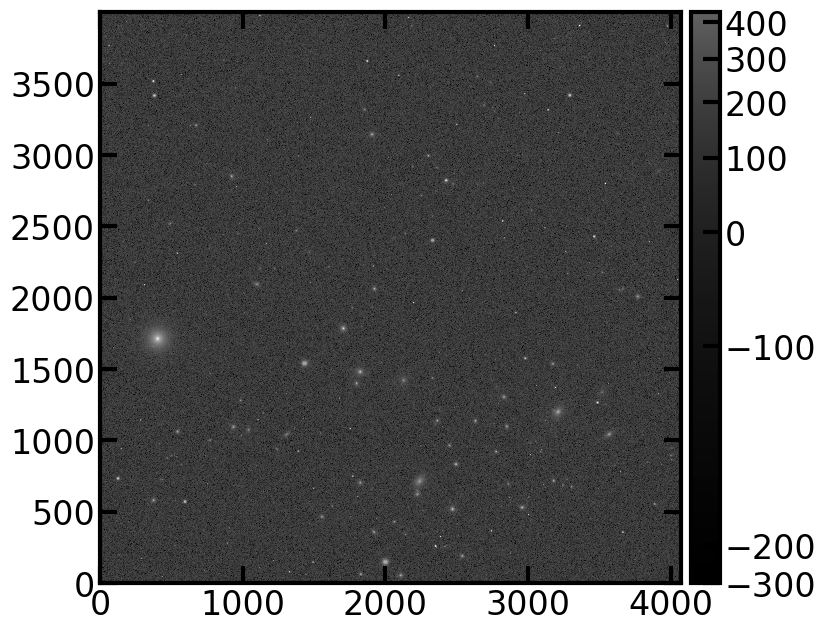

<Figure size 800x800 with 0 Axes>

In [8]:
# create a matplotlib.pyplot figure
fig = plt.figure()
# get an alias to the lsst.afw.display.Display() method
display = afwDisplay.Display(frame=fig)
# set the image stretch algorithm and range
display.scale('asinh', 'zscale')
# load the image into the display
display.mtv(calexp.image)
# show the corresponding pyplot figure
plt.show()

ruta = f'/home/luiseduardocantero/notebooks/pruebas/holix.png'

plt.savefig(ruta, bbox_inches='tight',pad_inches = 0, dpi=36) # dpi=36 para que den 217x217 pxls


# clean up memory
remove_figure(fig)

In [22]:
type(fig)

matplotlib.figure.Figure

To see the image axes in sky coordinates instead of pixel coordinates, a simple option is to use astropy's World Coordinate System (WCS) package, along with matplotlib.pyplot's `subplot`, `imshow`, and `grid` functions. 
Recall that we imported `matplotlib.pyplot` as `plt` already, and that we imported the `astropy.wcs.WCS` function as simply `WCS`.
Find more information about [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) (`cmap`).

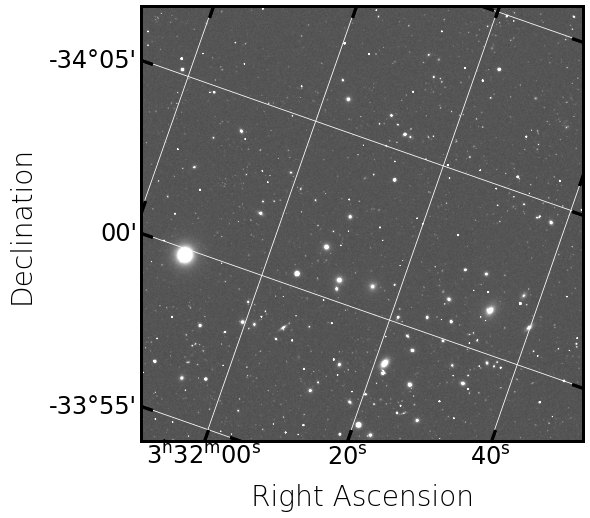

In [23]:
fig = plt.figure()

# Set the figure's projection to be the WCS of the calexp
plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))

# Define the extent in pixel coordinates using the bounding box
calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                 calexp.getBBox().beginY, calexp.getBBox().endY)

# Display the calexp image data array using the gray colormap (cmap)
#  and use approximately the same min and max scale values as above
im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=calexp_extent, origin='lower')

# Add solid white grid lines
plt.grid(color='white', ls='solid')

# Label axes
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()

# Clean up memory
remove_figure(fig)

**Congratulations!** We've plotted an image in various ways using `lsst.afw.display`!

### 3.2: Use AFWDisplay to Visualize the Image and Mask Plane

The `calexp` returned by the butler contains more than just the image pixel values (see the Stack Club [calexp tutorial](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb) for more details). One other component is the mask associated with the image. A mask is composed of a set of "mask planes," 2D binary bit maps corresponding to pixels that are masked for various reasons (see [here](https://pipelines.lsst.io/v/DM-11392/getting-started/display.html#interpreting-displayed-mask-colors) for more details).

`afwDisplay` maps each bit in the mask plain to a specific display color. We can view this mapping using the code in the following cell. We can also use the `setMaskPlaneColor` method to change the colors that `afwDisplay` uses for each mask plane.

In [24]:
# Print the colors associated to each plane in the mask
print("Mask plane bit definitions:\n", display.getMaskPlaneColor())
print("\nMask plane methods:\n")
help(display.setMaskPlaneColor)

Mask plane bit definitions:
 {'BAD': 'red', 'CR': 'magenta', 'EDGE': 'yellow', 'INTERPOLATED': 'green', 'SATURATED': 'green', 'DETECTED': 'blue', 'DETECTED_NEGATIVE': 'cyan', 'SUSPECT': 'yellow', 'NO_DATA': 'orange', 'INTRP': 'green', 'SAT': 'green'}

Mask plane methods:

Help on method setMaskPlaneColor in module lsst.afw.display.interface:

setMaskPlaneColor(name, color=None) method of lsst.afw.display.interface.Display instance
    Request that mask plane name be displayed as color
    
    Parameters
    ----------
    name : `str` or `dict`
        Name of mask plane or a dictionary of name -> colorName
    color : `str`
        The name of the color to use (must be `None` if ``name`` is a `dict`)
    
        Colors may be specified as any X11-compliant string (e.g. `"orchid"`), or by one
        of the following constants in `lsst.afw.display` : `BLACK`, `WHITE`, `RED`, `BLUE`,
        `GREEN`, `CYAN`, `MAGENTA`, `YELLOW`.
    
        If the color is "ignore" (or `IGNORE`) then

Let's plot the image and mask plane side-by-side using matplotlib subplots.

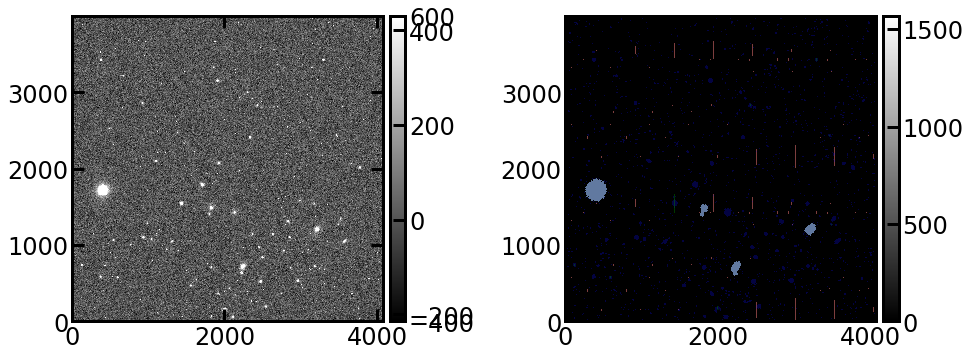

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp.image)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.mtv(calexp.mask)
plt.tight_layout()
plt.show()
remove_figure(fig)

`afwDisplay` also provides a nice interface for plotting the mask on top of the image by providing the `calexp.maskedImage`. The mask will also be plotted on top of the image if you pass the `calexp` itself to `mtv` (as is done later in this notebook).

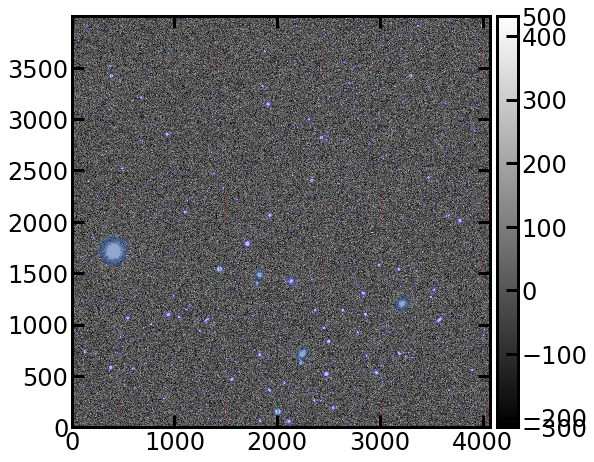

In [26]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('linear', 'zscale')
display.mtv(calexp.maskedImage)
plt.show()
remove_figure(fig)

To investigate the mask in a bit more detail, we'll follow the same steps as above to display the image, but we'll add a few modifications

1. We explicitly set the transparency of the overplotted mask
   (as a percentage: 0 = opaque, 100 = transparent)
2. We explicitly set the color of the 'DETECTED' mask plane to 'blue' (i.e., all pixels associated with detected objects).
3. We pass the full `calexp` object to `mtv` instead of just the image plane.

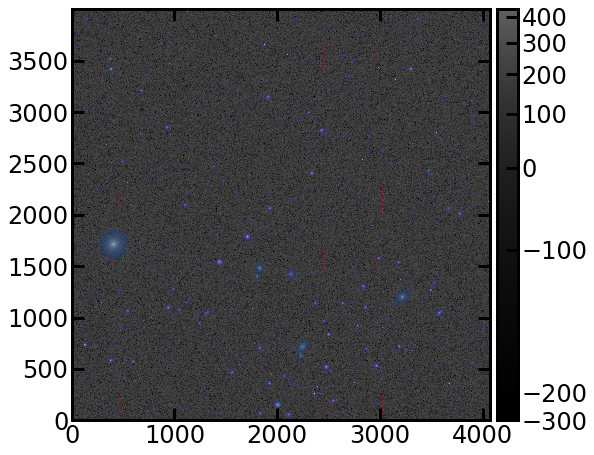

In [27]:
# create a matplotlib.pyplot figure
fig, ax = plt.subplots()
# get an alias to the lsst.afw.display.Display() method
display = afwDisplay.Display(frame=fig)
# set the image stretch algorithm and range
display.scale('asinh', 'zscale')
# set the transparency of the mask plane (0%=opaque, 100%=transparent)
display.setMaskTransparency(80)
# set the color for a single plane in the mask
display.setMaskPlaneColor('DETECTED', 'blue')
# load the image and mask plane into the display
display.mtv(calexp)
# show the corresponding pyplot figure
plt.show()
# clean up memory
remove_figure(fig)

### 3.3 More Information about lsst.afw.display

To find more information about `lsst.afw.display`, we can print the method list to see what's available. The next cell will print `lsst.afw.display` methods to the screen.

In [28]:
method_list = [fun for fun in dir(display) if callable(getattr(display, fun))]
print(method_list)

['Buffering', '_Buffering', '__class__', '__del__', '__delattr__', '__dir__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'close', 'delAllDisplays', 'dot', 'erase', 'flush', 'getActiveCallbackKeys', 'getDefaultBackend', 'getDefaultFrame', 'getDisplay', 'getMaskPlaneColor', 'getMaskTransparency', 'incrDefaultFrame', 'interact', 'line', 'maskColorGenerator', 'mtv', 'pan', 'scale', 'setCallback', 'setDefaultBackend', 'setDefaultFrame', 'setDefaultImageColormap', 'setDefaultMaskPlaneColor', 'setDefaultMaskTransparency', 'setImageColormap', 'setMaskPlaneColor', 'setMaskTransparency', 'show', 'zoom']


If you'd like to learn more about any given function, please see the [`lsst.afw.display` source code](https://github.com/lsst/afw/tree/master/python/lsst/afw/display).

You can also read the API documentation about the above functions using the Jupyter notebook `help()` function:

In [29]:
help(display.scale)

Help on method scale in module lsst.afw.display.interface:

scale(algorithm, min, max=None, unit=None, *args, **kwargs) method of lsst.afw.display.interface.Display instance
    Set the range of the scaling from DN in the image to the image display
    
    Parameters
    ----------
    algorithm : `str`
        Desired scaling (e.g. "linear" or "asinh")
    min
        Minimum value, or "minmax" or "zscale"
    max
        Maximum value (must be `None` for minmax|zscale)
    unit
        Units for min and max (e.g. Percent, Absolute, Sigma; `None` if min==minmax|zscale)
    *args
        Optional arguments to the backend
    **kwargs
        Optional keyword arguments to the backend



In [30]:
help(display.mtv)

Help on method mtv in module lsst.afw.display.interface:

mtv(data, title='', wcs=None) method of lsst.afw.display.interface.Display instance
    Display an `~lsst.afw.image.Image` or `~lsst.afw.image.Mask` on a display
    
    Notes
    -----
    Historical note: the name "mtv" comes from Jim Gunn's forth imageprocessing
    system, Mirella (named after Mirella Freni); The "m" stands for Mirella.



## 4. Extract a coadd cutout image

Up until now, we have been examining an image from a single CCD detector taken during a single visit. For the rest of this notebook, we will switch to examining coadded images made up of multiple exposures that have been combined. Let's start by taking a look at what a full 4k x 4k pixel coadd "patch" image looks like. 

We start by grabbing a `deepCoadd` image and displaying it:

In [31]:
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
datasetType = 'deepCoadd'
# Retrieve the data using the `butler` instance and its function `get()`
coadd = butler.get(datasetType, **dataId)

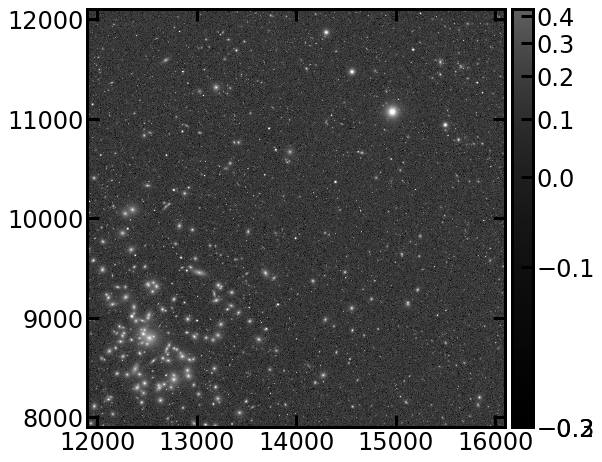

In [32]:
# create a matplotlib.pyplot figure
fig, ax = plt.subplots()
# get an alias to the lsst.afw.display.Display() method
display = afwDisplay.Display(frame=fig)
# set the image stretch algorithm and range
display.scale('asinh', 'zscale')
# load the image into the display
display.mtv(coadd.image)
plt.show()
# clean up memory
remove_figure(fig)

Wow, check out that rich galaxy cluster in the lower-left portion of the image! 

The image above is displaying pixel coordinates (note that the coadd patch is part of a larger coadd image called a "tract", so the pixel values do not start at 0,0), but in general it is more useful to be able to select a region based on RA, Dec coordinates. To do this, we'll use the world coordinate system (WCS) object associated with the image.

In [33]:
# First, we need to extract the WCS solution, which provides the mapping
#   between XY pixel values and sky coordinates:
wcs = coadd.getWcs()

# Print the WCS info to see what it contains:
print(wcs)

FITS standard SkyWcs:
Sky Origin: (55.6521739130, -31.9834710744)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


In [34]:
# The cluster seems to be centered at about (X, Y) ~ (12500, 8500).
# We can use the "pixelToSky" method of the WCS to get the sky coordinates:
radec = wcs.pixelToSky(12500, 8500)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

55.7506834813934 -32.28892993702273


Now that we have the RA, Dec coordinates of the cluster, we would like to grab a small cutout of the coadded image at this location. To do this, we've defined a user function [`cutout_coadd` at the beginning of the notebook](#cutout_coadd). This function extracts a cutout from a deep coadd image at a given RA, Dec position and desired image size.

In [35]:
help(cutout_coadd)

Help on function cutout_coadd in module __main__:

cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd', skymap=None, cutoutSideLength=51, **kwargs)
    Produce a cutout from a coadd at the given ra, dec position.
    
    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.
    
    Returns
    -------
    MaskedImage



We can call this function to extract a cutout image that is centered on the galaxy cluster.

In [36]:
# Select a position at roughly the center of the galaxy cluster:
cutout_image = cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=501)
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)

The size of the cutout in pixels is:  (501, 501)


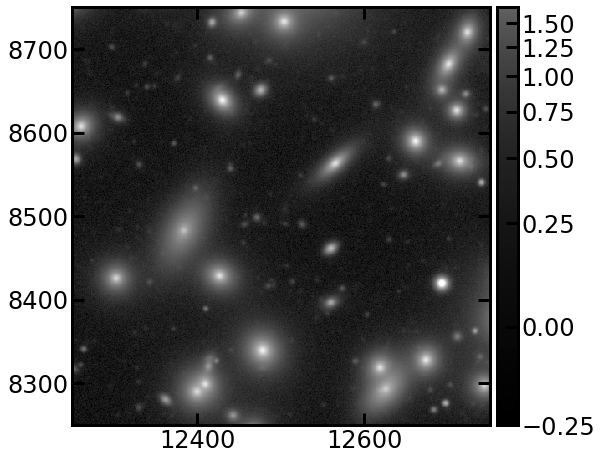

In [37]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
plt.show()
remove_figure(fig)

## 5. Overplotting catalog sources

Now that we've been able to examine the coadd image and make a cutout, we may be interested in the corresponding catalog of astronomical sources that was extracted from this image by the LSST Science Pipelines. The TAP service is the recommended way to retrieve catalog data for a notebook, and there are examples on how to do this in previous [tutorials](https://github.com/rubin-dp0/tutorial-notebooks).

Here we demonstrate how to use the Butler to access to catalog data. The full catalogs are very large and it is not feasible to try and retrieve them in their entirety. Instead, we retrieve only the catalog data for the coadd patch that we've been looking at. Note that this call to `butler.get` uses the same `dataId` that we used to access the image, but a different `datasetType`.

In [38]:
print("Retrieving catalog from:\n", dataId)
datasetType = 'objectTable'
coadd_obj = butler.get(datasetType, dataId=dataId)
print(f"Retrieved {len(coadd_obj)} catalog objects")

Retrieving catalog from:
 {'tract': 4431, 'patch': 17, 'band': 'i'}
Retrieved 37026 catalog objects


This call has provide us with a pandas DataFrame containing the multi-band object catalog (`coadd_obj`). You can refer to the Data Products Definitions Document (DPDD) at [dp0-2.lsst.io](https://dp0-2.lsst.io) to find out more about the columns of this table.

In [39]:
print(type(coadd_obj))
coadd_obj

<class 'pandas.core.frame.DataFrame'>


column,coord_dec,detect_isDeblendedSource,footprintArea,shape_xx,merge_peak_sky,refExtendedness,sky_object,deblend_nChild,detect_fromBlend,x,...,u_kronFlux_flag,u_kronFlux_flag_bad_radius,u_kronFlux_flag_bad_shape,u_kronFlux_flag_bad_shape_no_psf,u_kronFlux_flag_edge,u_kronFlux_flag_no_fallback_radius,u_kronFlux_flag_no_minimum_radius,u_kronFlux_flag_small_radius,u_kronFlux_flag_used_minimum_radius,u_kronFlux_flag_used_psf_radius
objectId,,,,,,,,,,,,,,,,,,,,,
1909948454470156289,-32.321901,True,85,11.079702,False,NaN,False,1,False,12022.000000,...,True,False,True,False,True,False,False,False,False,False
1909948454470156290,-32.317513,False,46337,10.072662,False,1.0,False,71,False,12709.547949,...,False,False,False,False,False,False,False,False,False,False
1909948454470156292,-32.321009,False,26388,7.936708,False,NaN,False,34,False,13088.000000,...,True,False,True,False,False,False,False,False,False,False
1909948454470156293,-32.321966,True,170,9.769333,False,NaN,False,1,False,13725.000000,...,True,False,True,False,True,False,False,False,False,False
1909948454470156294,-32.321188,False,471,3.956755,False,NaN,False,2,False,13741.000000,...,True,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909948454470206951,-32.192869,False,132,5.962306,False,1.0,False,0,False,13972.564211,...,False,False,False,False,False,False,False,False,False,False
1909948454470206952,-32.151663,False,144,5.779773,False,1.0,False,0,False,14718.496074,...,False,False,False,False,False,False,False,False,False,False
1909948454470206953,-32.134073,False,132,5.545843,False,1.0,False,0,False,12685.637631,...,False,True,False,False,False,False,False,False,False,True


Let's select the catalog sources within the bounding box of our cutout and plot them on top of our image using their pixel coordinates. To perform this operation, we use the pixel coordinates of the object centroid (`coadd_obj.x, coadd_obj.y`).

In [40]:
cutout_bbox = cutout_image.getBBox()
sel = cutout_bbox.contains(coadd_obj.x, coadd_obj.y)
cutout_obj = coadd_obj.loc[sel]

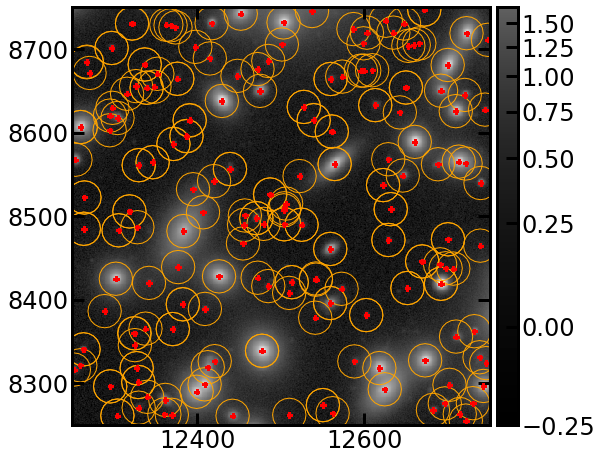

In [41]:
# Display the image cutout
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)

# We use display buffering to avoid re-drawing the image
#  after each source is plotted
with display.Buffering():
    for i, s in cutout_obj.iterrows():
        display.dot('+', s.x, s.y, ctype=afwDisplay.RED)
        display.dot('o', s.x, s.y, size=20, ctype='orange')

plt.show()
remove_figure(fig)

Note that since the object catalog is assembled from the multi-band coadd images, not every source will necessarily be detected in our i-band image.

## 6. Plot an RGB composite image

We've found a pretty galaxy cluster, but what if we want to know about the colors of the stars and galaxies in that image? To do that, we can extract images taken with three different filters and then assign those images to the RGB channels of a color image.

We will use the `MultiBandExposure` object type from the LSST Science Pipelines `afw.image` package. However, one could also create a similar function that simply accepts three separate images without combining them into a MultiBand object.

In [13]:
cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                              datasetType='deepCoadd', cutoutSideLength=701)
cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                              datasetType='deepCoadd', cutoutSideLength=701)
cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                              datasetType='deepCoadd', cutoutSideLength=701)

# Multiband exposures need a list of images and filters
coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

NameError: name 'ra' is not defined

Now we are ready to create the RGB (where, in case you're unfamiliar, the RGB denotes "red," "green," and "blue" channels) image. We will assign the g, r, and i-bands to the B, G, and R channels (i.e., g-band, as the bluest filter, will be in the blue channel, r-band in the green channel, and i-band as red). We will use the function [`create_rgb`](#create_rgb) that we defined at the [top of this notebook](#create_rgb).

Finally, we will plot two versions of the image to demonstrate how you can change the relative scaling of each RGB channel to produce an image better highlights certain features. You can experiment with the "scale = []" keyword, or including different bands besides _gri_.

**Congratulations** - you have now learned how to display images, create cutouts centered on a given position, and make multi-band color images. Enjoy exploring the DP0 images!

## Additional Documentation

If you'd like some more information on `lsst.afw.display`, please have a look at the following websites:

* [Info on image indexing conventions.](https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html)  
* [afw.display Doxygen website](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/namespacelsst_1_1afw_1_1display.html)  
* [afw.display GitHub website](https://github.com/RobertLuptonTheGood/afw/tree/master/python/lsst/afw/display)  
* [Getting Started on Image Display (pipelines.lsst.io)](https://pipelines.lsst.io/getting-started/display.html)